### Piotr Klimczak 1SIiUM2 239533
Pracowano na SI Lab2 (suwnica)

In [42]:
import vrep 
import sys
import time 
import numpy as np
import skfuzzy as fuzz 
import matplotlib.pyplot as plt 
from skfuzzy import control as ctrl 

### Mamdani

In [43]:
odleglosc = ctrl.Antecedent(np.arange(-1.42, 1.42, 0.01), 'odleglosc') #zmierzona odleglosc
wychylenie = ctrl.Antecedent(np.arange(0.0, 0.22, 0.01), 'wychylenie')
#zalezne od predkosci, ustawilem na sztywno 4.5, wyprintowalem: 
#abs (position_cuboid[0] - position_load[0])
#znalazlem max, znalazlem min, odjalem od siebie, wyszło 0.31
predkosc  = ctrl.Consequent(np.arange(-3.5, 3.5, 0.01), 'predkosc') #predkosc na kolach, też 4.5

predkosc.automf(5) #5 stopni predkosci

odleglosc['za_celem'] = fuzz.trapmf(odleglosc.universe, [-1.42, -1.42, -1.2, 0]) 
odleglosc['przed_celem'] = fuzz.trapmf(odleglosc.universe, [0, 1.2, 1.42, 1.42]) 
odleglosc['w_punkt'] = fuzz.trimf(odleglosc.universe, [-1.2, 0, 1.2]) 

wychylenie['duze'] = fuzz.trapmf(wychylenie.universe, [0.07, 0.15, 0.22, 0.22]) #trapezy
wychylenie['male'] = fuzz.trapmf(wychylenie.universe, [0.0, 0.0, 0.07, 0.15])

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


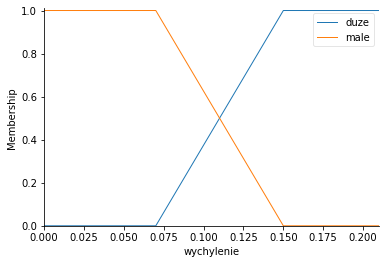

In [44]:
wychylenie.view()

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


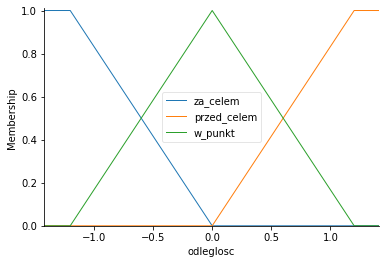

In [45]:
odleglosc.view()

F:\Anaconda\envs\smpd\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


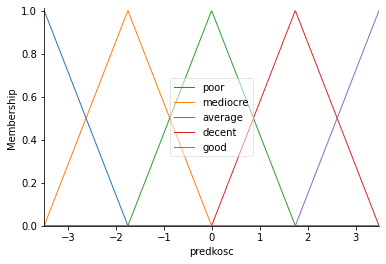

In [46]:
predkosc.view()

In [47]:
rule1 = ctrl.Rule(odleglosc['przed_celem'] & wychylenie['male'], predkosc['good']) #pelna predkosc
rule2 = ctrl.Rule(odleglosc['przed_celem'] & wychylenie['duze'], predkosc['decent']) #50%
rule3 = ctrl.Rule(odleglosc['w_punkt'], predkosc['average']) #0%
rule4 = ctrl.Rule(odleglosc['za_celem'] & wychylenie['duze'], predkosc['mediocre']) #50%
rule5 = ctrl.Rule(odleglosc['za_celem'] & wychylenie['male'], predkosc['poor']) #pelna predkosc

speed_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5])
speeding = ctrl.ControlSystemSimulation(speed_ctrl)

In [48]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

# get handles to robot drivers
err_code, lf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LF", vrep.simx_opmode_blocking)
err_code, lb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LB", vrep.simx_opmode_blocking)
err_code, rb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RB", vrep.simx_opmode_blocking)
err_code, rf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RF", vrep.simx_opmode_blocking)


Connected to remote API server


In [49]:
# get handle to the load
err_code, load_handle = vrep.simxGetObjectHandle(clientID, "Load", vrep.simx_opmode_blocking)
err_code2, cuboid_handle = vrep.simxGetObjectHandle(clientID, "Cuboid", vrep.simx_opmode_blocking)

#get first position of load
err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_streaming)
err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_streaming)

#get positions of load
t = time.time()
while (time.time()-t) < 20:
    err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_buffer)
    err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_buffer)
    if err_code==0:
        
        speeding.input['odleglosc']  = position_cuboid[0]
        speeding.input['wychylenie'] = abs(position_cuboid[0] - position_load[0])
        speeding.compute()
        velocity = speeding.output['predkosc']
                
        err_code = vrep.simxSetJointTargetVelocity(clientID,lb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,lf_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rf_motor_handle,velocity,vrep.simx_opmode_streaming) 
        
        print("Pozycja wózka: ", position_cuboid[0])
        print("Wychylenie: ", abs(position_cuboid[0] - position_load[0]))
        print("Prędkość wózka: ", velocity)
        print("\n")
        

Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609024048
Wychylenie:  0.0013538599014282227
Prędkość wózka:  2.9074928572011967


Pozycja wózka:  1.3999992609

Pozycja wózka:  1.2571134567260742
Wychylenie:  0.14195728302001953
Prędkość wózka:  1.7510775586433867


Pozycja wózka:  1.2571134567260742
Wychylenie:  0.14195728302001953
Prędkość wózka:  1.7510775586433867


Pozycja wózka:  1.2571134567260742
Wychylenie:  0.14195728302001953
Prędkość wózka:  1.7510775586433867


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:  0.14465761184692383
Prędkość wózka:  1.7463170324485904


Pozycja wózka:  1.2458586692810059
Wychylenie:

Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132413864135742
Prędkość wózka:  2.474645108898657


Pozycja wózka:  1.1466872692108154
Wychylenie:  0.04132

Pozycja wózka:  0.9625177383422852
Wychylenie:  0.045119285583496094
Prędkość wózka:  1.6556491607208579


Pozycja wózka:  0.9625177383422852
Wychylenie:  0.045119285583496094
Prędkość wózka:  1.6556491607208579


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05970728397369385
Prędkość wózka:  1.6251003705939213


Pozycja wózka:  0.952088475227356
Wychylenie:  0.05

Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280953884124756
Prędkość wózka:  1.338523605918334


Pozycja wózka:  0.8863248825073242
Wychylenie:  0.11280

Pozycja wózka:  0.8378711938858032
Wychylenie:  0.08074986934661865
Prędkość wózka:  1.3520109123262525


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8297402262687683
Wychylenie:  0.061972618103027344
Prędkość wózka:  1.3276878564786248


Pozycja wózka:  0.8215031623840332
Wyc

Pozycja wózka:  0.7599369883537292
Wychylenie:  0.16833066940307617
Prędkość wózka:  1.0577542852555835


Pozycja wózka:  0.7599369883537292
Wychylenie:  0.16833066940307617
Prędkość wózka:  1.0577542852555835


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:  0.17860442399978638
Prędkość wózka:  1.0492558873292426


Pozycja wózka:  0.7529343962669373
Wychylenie:

Pozycja wózka:  0.6968001127243042
Wychylenie:  0.022126615047454834
Prędkość wózka:  1.0838765193293254


Pozycja wózka:  0.6968001127243042
Wychylenie:  0.022126615047454834
Prędkość wózka:  1.0838765193293254


Pozycja wózka:  0.6968001127243042
Wychylenie:  0.022126615047454834
Prędkość wózka:  1.0838765193293254


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0.0585174560546875
Prędkość wózka:  1.0731914382900962


Pozycja wózka:  0.6902700662612915
Wychylenie:  0

Pozycja wózka:  0.6361175775527954
Wychylenie:  0.12662667036056519
Prędkość wózka:  0.9904444659565246


Pozycja wózka:  0.6361175775527954
Wychylenie:  0.12662667036056519
Prędkość wózka:  0.9904444659565246


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460144043
Prędkość wózka:  1.103116478907445


Pozycja wózka:  0.6307269334793091
Wychylenie:  0.1070704460

Pozycja wózka:  0.578826367855072
Wychylenie:  0.05481827259063721
Prędkość wózka:  0.9023870658513172


Pozycja wózka:  0.578826367855072
Wychylenie:  0.05481827259063721
Prędkość wózka:  0.9023870658513172


Pozycja wózka:  0.578826367855072
Wychylenie:  0.05481827259063721
Prędkość wózka:  0.9023870658513172


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.06856966018676758
Prędkość wózka:  0.8945122203999253


Pozycja wózka:  0.573408842086792
Wychylenie:  0.068569

Pozycja wózka:  0.5247567892074585
Wychylenie:  0.1314096450805664
Prędkość wózka:  0.835403384358846


Pozycja wózka:  0.5247567892074585
Wychylenie:  0.1314096450805664
Prędkość wózka:  0.835403384358846


Pozycja wózka:  0.5247567892074585
Wychylenie:  0.1314096450805664
Prędkość wózka:  0.835403384358846


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11717537045478821
Prędkość wózka:  0.9319358686402763


Pozycja wózka:  0.5199954509735107
Wychylenie:  0.11

Pozycja wózka:  0.47058922052383423
Wychylenie:  0.16665351390838623
Prędkość wózka:  0.716565346808579


Pozycja wózka:  0.47058922052383423
Wychylenie:  0.16665351390838623
Prędkość wózka:  0.716565346808579


Pozycja wózka:  0.47058922052383423
Wychylenie:  0.16665351390838623
Prędkość wózka:  0.716565346808579


Pozycja wózka:  0.47058922052383423
Wychylenie:  0.16665351390838623
Prędkość wózka:  0.716565346808579


Pozycja wózka:  0.47058922052383423
Wychylenie:  0.16665351390838623
Prędkość wózka:  0.716565346808579


Pozycja wózka:  0.46572747826576233
Wychylenie:  0.1745133101940155
Prędkość wózka:  0.710734887377649


Pozycja wózka:  0.46572747826576233
Wychylenie:  0.1745133101940155
Prędkość wózka:  0.710734887377649


Pozycja wózka:  0.46572747826576233
Wychylenie:  0.1745133101940155
Prędkość wózka:  0.710734887377649


Pozycja wózka:  0.46572747826576233
Wychylenie:  0.1745133101940155
Prędkość wózka:  0.710734887377649


Pozycja wózka:  0.46572747826576233
Wychylenie:  0

Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie:  0.04815095663070679
Prędkość wózka:  0.701183624706678


Pozycja wózka:  0.43591031432151794
Wychylenie

Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
Wychylenie:  0.10259494185447693
Prędkość wózka:  0.7647653645033773


Pozycja wózka:  0.41085949540138245
W

Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:  0.10881251096725464
Prędkość wózka:  0.7117112679815685


Pozycja wózka:  0.3796813189983368
Wychylenie:

Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie:  0.0278489887714386
Prędkość wózka:  0.5892961605066569


Pozycja wózka:  0.35539644956588745
Wychylenie

Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
Wychylenie:  0.11249163746833801
Prędkość wózka:  0.6276612427635014


Pozycja wózka:  0.33086737990379333
W

Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:  0.10815697908401489
Prędkość wózka:  0.5847732601204423


Pozycja wózka:  0.3062753677368164
Wychylenie:

Pozycja wózka:  0.283245712518692
Wychylenie:  0.0890534371137619
Prędkość wózka:  0.5442204758968553


Pozycja wózka:  0.283245712518692
Wychylenie:  0.0890534371137619
Prędkość wózka:  0.5442204758968553


Pozycja wózka:  0.283245712518692
Wychylenie:  0.0890534371137619
Prędkość wózka:  0.5442204758968553


Pozycja wózka:  0.283245712518692
Wychylenie:  0.0890534371137619
Prędkość wózka:  0.5442204758968553


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.11221498250961304
Prędkość wózka:  0.538910027988923


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.11221498250961304
Prędkość wózka:  0.538910027988923


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.11221498250961304
Prędkość wózka:  0.538910027988923


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.11221498250961304
Prędkość wózka:  0.538910027988923


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.11221498250961304
Prędkość wózka:  0.538910027988923


Pozycja wózka:  0.2802451252937317
Wychylenie:  0.112214982

Pozycja wózka:  0.24190175533294678
Wychylenie:  0.01836150884628296
Prędkość wózka:  0.42503741942154233


Pozycja wózka:  0.24190175533294678
Wychylenie:  0.01836150884628296
Prędkość wózka:  0.42503741942154233


Pozycja wózka:  0.24190175533294678
Wychylenie:  0.01836150884628296
Prędkość wózka:  0.42503741942154233


Pozycja wózka:  0.24190175533294678
Wychylenie:  0.01836150884628296
Prędkość wózka:  0.42503741942154233


Pozycja wózka:  0.23930104076862335
Wychylenie:  0.03817306458950043
Prędkość wózka:  0.42111203941833364


Pozycja wózka:  0.23930104076862335
Wychylenie:  0.03817306458950043
Prędkość wózka:  0.42111203941833364


Pozycja wózka:  0.23930104076862335
Wychylenie:  0.03817306458950043
Prędkość wózka:  0.42111203941833364


Pozycja wózka:  0.23930104076862335
Wychylenie:  0.03817306458950043
Prędkość wózka:  0.42111203941833364


Pozycja wózka:  0.23930104076862335
Wychylenie:  0.03817306458950043
Prędkość wózka:  0.42111203941833364


Pozycja wózka:  0.2393010407

Pozycja wózka:  0.22363877296447754
Wychylenie:  0.10559764504432678
Prędkość wózka:  0.43723256773090957


Pozycja wózka:  0.22363877296447754
Wychylenie:  0.10559764504432678
Prędkość wózka:  0.43723256773090957


Pozycja wózka:  0.22363877296447754
Wychylenie:  0.10559764504432678
Prędkość wózka:  0.43723256773090957


Pozycja wózka:  0.22363877296447754
Wychylenie:  0.10559764504432678
Prędkość wózka:  0.43723256773090957


Pozycja wózka:  0.22363877296447754
Wychylenie:  0.10559764504432678
Prędkość wózka:  0.43723256773090957


Pozycja wózka:  0.22098448872566223
Wychylenie:  0.10825192928314209
Prędkość wózka:  0.43238920784709567


Pozycja wózka:  0.22098448872566223
Wychylenie:  0.10840728878974915
Prędkość wózka:  0.43238920784709567


Pozycja wózka:  0.22098448872566223
Wychylenie:  0.10840728878974915
Prędkość wózka:  0.43238920784709567


Pozycja wózka:  0.22098448872566223
Wychylenie:  0.10840728878974915
Prędkość wózka:  0.43238920784709567


Pozycja wózka:  0.2209844887

Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.20560066401958466
Wychylenie:  0.07558940351009369
Prędkość wózka:  0.3752616841955766


Pozycja wózka:  0.2031213343143463
Wychylenie:  0.07806873321533203
Prędkość wózka:  0.3777873733621199


Pozycja wózka:  0.2031213343143463
Wychylenie:  0.061246395111083984
Prędkość wózka:  0.3654624490771402


Pozycja wózka:  0.2031213343143463
Wychylenie:  0.061246395111083984
Prędkość wózka:  0.3654624490771402


Pozycja wózka:  0.2031213343143463
Wyc

Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.18767860531806946
Wychylenie:  0.09161180257797241
Prędkość wózka:  0.37100535450848937


Pozycja wózka:  0.1876786053

Pozycja wózka:  0.17480702698230743
Wychylenie:  0.14265042543411255
Prędkość wózka:  0.3297518477892238


Pozycja wózka:  0.17480702698230743
Wychylenie:  0.14265042543411255
Prędkość wózka:  0.3297518477892238


Pozycja wózka:  0.17480702698230743
Wychylenie:  0.14265042543411255
Prędkość wózka:  0.3297518477892238


Pozycja wózka:  0.17480702698230743
Wychylenie:  0.14265042543411255
Prędkość wózka:  0.3297518477892238


Pozycja wózka:  0.17480702698230743
Wychylenie:  0.14265042543411255
Prędkość wózka:  0.3297518477892238


Pozycja wózka:  0.17284490168094635
Wychylenie:  0.13175035268068314
Prędkość wózka:  0.3432602973460125


Pozycja wózka:  0.17284490168094635
Wychylenie:  0.13175035268068314
Prędkość wózka:  0.3432602973460125


Pozycja wózka:  0.17284490168094635
Wychylenie:  0.13175035268068314
Prędkość wózka:  0.3432602973460125


Pozycja wózka:  0.17284490168094635
Wychylenie:  0.13175035268068314
Prędkość wózka:  0.3432602973460125


Pozycja wózka:  0.17284490168094635
W

Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.16094346344470978
Wychylenie:  0.01803828775882721
Prędkość wózka:  0.2977119494380363


Pozycja wózka:  0.15909959375858307
Wychylenie:  0.04696929454803467
Prędkość wózka:  0.2946685297476748


Pozycja wózka:  0.15909959375858307
Wychylenie:  0.04696929454803467
Prędkość wózka:  0.2946685297476748


Pozycja wózka:  0.15909959375858307
Wychylenie:  0.04696929454803467
Prędkość wózka:  0.2946685297476748


Pozycja wózka:  0.15909959375858307
W

Pozycja wózka:  0.14637142419815063
Wychylenie:  0.1398594081401825
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.14637142419815063
Wychylenie:  0.13474291563034058
Prędkość wózka:  0.29305763581594324


Pozycja wózka:  0.1445230394601822
Wychylenie:  0.126584991812706
Prędkość wózka:  0.28951958259674787


Pozycja wózka:  0.14452303946018

Pozycja wózka:  0.13592150807380676
Wychylenie:  0.0635739117860794
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wychylenie:  0.04168589413166046
Prędkość wózka:  0.2557561835541453


Pozycja wózka:  0.13592150807380676
Wy

Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.12228584289550781
Wychylenie:  0.09861625730991364
Prędkość wózka:  0.24655420037502196


Pozycja wózka:  0.1207776814699173
Wychylenie:  0.10476871579885483
Prędkość wózka:  0.2436133998402793


Pozycja wózka:  0.120777681469

Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11207984387874603
Wychylenie:  0.0872042179107666
Prędkość wózka:  0.22658481118882295


Pozycja wózka:  0.11067251861095428
Wychylenie:  0.0734562799334526
Prędkość wózka:  0.21450161716316923


Pozycja wózka:  0.11067251861095428
Wychylenie:  0.0734562799334526
Prędkość wózka:  0.21450161716316923


Pozycja wózka:  0.11067251861095428
Wychylenie:  0.0734562799334526
Prędkość wózka:  0.21450161716316923


Pozycja wózka:  0.11067251861095428
W

Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.10165643692016602
Wychylenie:  0.08206997811794281
Prędkość wózka:  0.20602888473290057


Pozycja wózka:  0.1016564369

Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09436341375112534
Wychylenie:  0.1373123899102211
Prędkość wózka:  0.19153883376788627


Pozycja wózka:  0.09318757057189941
W

Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.08760769665241241
Wychylenie:  0.018981963396072388
Prędkość wózka:  0.17021074086884888


Pozycja wózka:  0.0

Pozycja wózka:  0.08129069954156876
Wychylenie:  0.11498252302408218
Prędkość wózka:  0.16534000731790605


Pozycja wózka:  0.08129069954156876
Wychylenie:  0.11498252302408218
Prędkość wózka:  0.16534000731790605


Pozycja wózka:  0.08129069954156876
Wychylenie:  0.11498252302408218
Prędkość wózka:  0.16534000731790605


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603
Wychylenie:  0.12285656481981277
Prędkość wózka:  0.16328927604806062


Pozycja wózka:  0.0802735909819603

Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.07100899517536163
Wychylenie:  0.013475485146045685
Prędkość wózka:  0.1392179696167971


Pozycja wózka:  0.0701407939195633
Wychylenie:  0.00309927761554718
Prędkość wózka:  0.13757176911456495


Pozycja wózka:  0.07014079391

Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.06209726259112358
Wychylenie:  0.11288564279675484
Prędkość wózka:  0.12632166572047462


Pozycja wózka:  0.0620972625

Pozycja wózka:  0.056907691061496735
Wychylenie:  0.029226645827293396
Prędkość wózka:  0.11215529747554125


Pozycja wózka:  0.056907691061496735
Wychylenie:  0.029226645827293396
Prędkość wózka:  0.11215529747554125


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.029881838709115982
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0.05625249817967415
Wychylenie:  0.003888878971338272
Prędkość wózka:  0.11088063873977817


Pozycja wózka:  0

Pozycja wózka:  0.05238325148820877
Wychylenie:  0.12947162985801697
Prędkość wózka:  0.10631266920581672


Pozycja wózka:  0.05238325148820877
Wychylenie:  0.12947162985801697
Prędkość wózka:  0.10631266920581672


Pozycja wózka:  0.05238325148820877
Wychylenie:  0.12947162985801697
Prędkość wózka:  0.10631266920581672


Pozycja wózka:  0.051698435097932816
Wychylenie:  0.13827406242489815
Prędkość wózka:  0.10489416390621921


Pozycja wózka:  0.051698435097932816
Wychylenie:  0.13827406242489815
Prędkość wózka:  0.10489416390621921


Pozycja wózka:  0.051698435097932816
Wychylenie:  0.13827406242489815
Prędkość wózka:  0.10489416390621921


Pozycja wózka:  0.051698435097932816
Wychylenie:  0.13827406242489815
Prędkość wózka:  0.10489416390621921


Pozycja wózka:  0.051698435097932816
Wychylenie:  0.13827406242489815
Prędkość wózka:  0.10489416390621921


Pozycja wózka:  0.050985634326934814
Wychylenie:  0.14153891801834106
Prędkość wózka:  0.10341618374952345


Pozycja wózka:  0.0509

Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.04733341187238693
Wychylenie:  0.05144463758915663
Prędkość wózka:  0.09337047279920348


Pozycja wózka:  0.0473334118

Pozycja wózka:  0.04349823296070099
Wychylenie:  0.09668135643005371
Prędkość wózka:  0.08784259339358057


Pozycja wózka:  0.04349823296070099
Wychylenie:  0.09668135643005371
Prędkość wózka:  0.08784259339358057


Pozycja wózka:  0.04349823296070099
Wychylenie:  0.09668135643005371
Prędkość wózka:  0.08784259339358057


Pozycja wózka:  0.04349823296070099
Wychylenie:  0.09668135643005371
Prędkość wózka:  0.08784259339358057


Pozycja wózka:  0.042989831417798996
Wychylenie:  0.10536958649754524
Prędkość wózka:  0.086779436966239


Pozycja wózka:  0.042989831417798996
Wychylenie:  0.10536958649754524
Prędkość wózka:  0.086779436966239


Pozycja wózka:  0.042989831417798996
Wychylenie:  0.10536958649754524
Prędkość wózka:  0.086779436966239


Pozycja wózka:  0.042989831417798996
Wychylenie:  0.10536958649754524
Prędkość wózka:  0.086779436966239


Pozycja wózka:  0.042989831417798996
Wychylenie:  0.10536958649754524
Prędkość wózka:  0.086779436966239


Pozycja wózka:  0.042989831417798

Pozycja wózka:  0.04002285748720169
Wychylenie:  0.09000232070684433
Prędkość wózka:  0.08058013702447714


Pozycja wózka:  0.04002285748720169
Wychylenie:  0.09000232070684433
Prędkość wózka:  0.08058013702447714


Pozycja wózka:  0.04002285748720169
Wychylenie:  0.09000232070684433
Prędkość wózka:  0.08058013702447714


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.03944849595427513
Wychylenie:  0.07944637909531593
Prędkość wózka:  0.07937695671562188


Pozycja wózka:  0.0394484959

Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.03677891939878464
Wychylenie:  0.009883292019367218
Prędkość wózka:  0.07225549845119512


Pozycja wózka:  0.036316901445388794
Wychylenie:  0.009421274065971375
Prędkość wózka:  0.07132111166214455


Pozycja wózka:  0.036316901445388794
Wychylenie:  0.027277049608528614
Prędkość wózka:  0.07132111166214455


Pozycja wózka:  0.036316901445388794
Wychylenie:  0.027277049608528614
Prędkość wózka:  0.07132111166214455


Pozycja wózka:  

Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.0338422954082489
Wychylenie:  0.11586363613605499
Prędkość wózka:  0.06759445254449291


Pozycja wózka:  0.033474963158369064
Wychylenie:  0.11549630388617516
Prędkość wózka:  0.06682059035658013


Pozycja wózka:  0.033474963158369064
Wychylenie:  0.12179626151919365
Prędkość wózka:  0.06682059035658013


Pozycja wózka:  0.033474963158369064
Wychylenie:  0.12179626151919365
Prędkość wózka:  0.06682059035658013


Pozycja wózka:  0.0334749631583

Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


Pozycja wózka:  0.030777404084801674
Wychylenie:  0.039102280512452126
Prędkość wózka:  0.060050273660204524


P

Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.028235619887709618
Wychylenie:  0.12107268907129765
Prędkość wózka:  0.05574235980490532


Pozycja wózka:  0.027916928753256798
Wychylenie:  0.13043282367289066
Prędkość wózka:  0.0550676088886773


Pozycja wózka:  0.027916928753256798
Wychylenie:  0.13043282367289066
Prędkość wózka:  0.0550676088886773


Pozycja wózka:  0.027

Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.02610642835497856
Wychylenie:  0.08299646899104118
Prędkość wózka:  0.05122797278228081


Pozycja wózka:  0.0257335156

Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.02372230961918831
Wychylenie:  0.0794864073395729
Prędkość wózka:  0.046155252596043625


Pozycja wózka:  0.0237223096

Pozycja wózka:  0.021801073104143143
Wychylenie:  0.09204189106822014
Prędkość wózka:  0.042057596325045694


Pozycja wózka:  0.021801073104143143
Wychylenie:  0.09204189106822014
Prędkość wózka:  0.042057596325045694


Pozycja wózka:  0.021801073104143143
Wychylenie:  0.09204189106822014
Prędkość wózka:  0.042057596325045694


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  0.021560978144407272
Wychylenie:  0.08311217650771141
Prędkość wózka:  0.04154601531712562


Pozycja wózka:  

Pozycja wózka:  0.020200781524181366
Wychylenie:  0.0037092193961143494
Prędkość wózka:  0.03817362694928558


Pozycja wózka:  0.020200781524181366
Wychylenie:  0.0037092193961143494
Prędkość wózka:  0.03817362694928558


Pozycja wózka:  0.020200781524181366
Wychylenie:  0.0037092193961143494
Prędkość wózka:  0.03817362694928558


Pozycja wózka:  0.019945340231060982
Wychylenie:  0.003964660689234734
Prędkość wózka:  0.03763931528269184


Pozycja wózka:  0.019945340231060982
Wychylenie:  0.02077496238052845
Prędkość wózka:  0.03763931528269184


Pozycja wózka:  0.019945340231060982
Wychylenie:  0.02077496238052845
Prędkość wózka:  0.03763931528269184


Pozycja wózka:  0.019662683829665184
Wychylenie:  0.037924790754914284
Prędkość wózka:  0.03704774359016389


Pozycja wózka:  0.019662683829665184
Wychylenie:  0.037924790754914284
Prędkość wózka:  0.03704774359016389


Pozycja wózka:  0.019662683829665184
Wychylenie:  0.037924790754914284
Prędkość wózka:  0.03704774359016389


Pozycja w

Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.01840626448392868
Wychylenie:  0.11598121374845505
Prędkość wózka:  0.03480606941345259


Pozycja wózka:  0.0184062644

Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wychylenie:  0.04561672918498516
Prędkość wózka:  0.03148853522481905


Pozycja wózka:  0.0170146394520998
Wy

Pozycja wózka:  0.015769077464938164
Wychylenie:  0.11008143238723278
Prędkość wózka:  0.02914578849484818


Pozycja wózka:  0.015769077464938164
Wychylenie:  0.11008143238723278
Prędkość wózka:  0.02914578849484818


Pozycja wózka:  0.015769077464938164
Wychylenie:  0.11008143238723278
Prędkość wózka:  0.02914578849484818


Pozycja wózka:  0.015769077464938164
Wychylenie:  0.11008143238723278
Prędkość wózka:  0.02914578849484818


Pozycja wózka:  0.015572922304272652
Wychylenie:  0.12113920785486698
Prędkość wózka:  0.028723818194128815


Pozycja wózka:  0.015572922304272652
Wychylenie:  0.12113920785486698
Prędkość wózka:  0.028723818194128815


Pozycja wózka:  0.015572922304272652
Wychylenie:  0.12113920785486698
Prędkość wózka:  0.028723818194128815


Pozycja wózka:  0.015572922304272652
Wychylenie:  0.12113920785486698
Prędkość wózka:  0.028723818194128815


Pozycja wózka:  0.015572922304272652
Wychylenie:  0.12113920785486698
Prędkość wózka:  0.028723818194128815


Pozycja wózka:

Pozycja wózka:  0.014609118923544884
Wychylenie:  0.08236133120954037
Prędkość wózka:  0.026655256656112666


Pozycja wózka:  0.014609118923544884
Wychylenie:  0.08236133120954037
Prędkość wózka:  0.026655256656112666


Pozycja wózka:  0.014609118923544884
Wychylenie:  0.08236133120954037
Prędkość wózka:  0.026655256656112666


Pozycja wózka:  0.014609118923544884
Wychylenie:  0.08236133120954037
Prędkość wózka:  0.026655256656112666


Pozycja wózka:  0.014447632245719433
Wychylenie:  0.08219984453171492
Prędkość wózka:  0.02630851700320996


Pozycja wózka:  0.014447632245719433
Wychylenie:  0.06255654152482748
Prędkość wózka:  0.02606965481280762


Pozycja wózka:  0.014447632245719433
Wychylenie:  0.06255654152482748
Prędkość wózka:  0.02606965481280762


Pozycja wózka:  0.014447632245719433
Wychylenie:  0.06255654152482748
Prędkość wózka:  0.02606965481280762


Pozycja wózka:  0.014447632245719433
Wychylenie:  0.06255654152482748
Prędkość wózka:  0.02606965481280762


Pozycja wózka: 

Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.013551661744713783
Wychylenie:  0.05504187010228634
Prędkość wózka:  0.024171308314151083


Pozycja wózka:  0.01344269048422575
Wychylenie:  0.0692181708291173
Prędkość wózka:  0.02394017659478233


Pozycja wózka:  0.01344269048422575
Wychylenie:  0.0692181708291173
Prędkość wózka:  0.02394017659478233


Pozycja wózka:  0.01344269048422575
Wychylenie:  0.0692181708291173
Prędkość wózka:  0.02394017659478233


Pozycja wózka:  0.0

Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012614172883331776
Wychylenie:  0.09708550851792097
Prędkość wózka:  0.02236544849832885


Pozycja wózka:  0.012478413060307503
Wychylenie:  0.09329120628535748
Prędkość wózka:  0.02207301784824116


Pozycja wózka:  0.0

Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wózka:  0.011743133887648582
Wychylenie:  0.03206990100443363
Prędkość wózka:  0.020328373646963625


Pozycja wó

Pozycja wózka:  0.011087908409535885
Wychylenie:  0.07779991533607244
Prędkość wózka:  0.01907413144622674


Pozycja wózka:  0.011087908409535885
Wychylenie:  0.07779991533607244
Prędkość wózka:  0.01907413144622674


Pozycja wózka:  0.011087908409535885
Wychylenie:  0.07779991533607244
Prędkość wózka:  0.01907413144622674


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.010951777920126915
Wychylenie:  0.09345746599137783
Prędkość wózka:  0.01878017710921861


Pozycja wózka:  0.0

Pozycja wózka:  0.010321957059204578
Wychylenie:  0.10877274442464113
Prędkość wózka:  0.017419322899270114


Pozycja wózka:  0.010321957059204578
Wychylenie:  0.10877274442464113
Prędkość wózka:  0.017419322899270114


Pozycja wózka:  0.010321957059204578
Wychylenie:  0.10877274442464113
Prędkość wózka:  0.017419322899270114


Pozycja wózka:  0.010321957059204578
Wychylenie:  0.10877274442464113
Prędkość wózka:  0.017419322899270114


Pozycja wózka:  0.010321957059204578
Wychylenie:  0.10877274442464113
Prędkość wózka:  0.017419322899270114


Pozycja wózka:  0.01020864024758339
Wychylenie:  0.09536265954375267
Prędkość wózka:  0.01717433130782971


Pozycja wózka:  0.01020864024758339
Wychylenie:  0.09536265954375267
Prędkość wózka:  0.01717433130782971


Pozycja wózka:  0.01020864024758339
Wychylenie:  0.09536265954375267
Prędkość wózka:  0.01717433130782971


Pozycja wózka:  0.01020864024758339
Wychylenie:  0.09536265954375267
Prędkość wózka:  0.01717433130782971


Pozycja wózka:  0.

Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.00964362733066082
Wychylenie:  0.04406200908124447
Prędkość wózka:  0.01584837053162592


Pozycja wózka:  0.0096436273

Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wózka:  0.009022185578942299
Wychylenie:  0.12071793340146542
Prędkość wózka:  0.014606492246023851


Pozycja wó

Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


Pozycja wózka:  0.008496591821312904
Wychylenie:  0.014273086562752724
Prędkość wózka:  0.013392193158819943


P

Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wózka:  0.007958518341183662
Wychylenie:  0.08148943074047565
Prędkość wózka:  0.012305254855328896


Pozycja wó

Pozycja wózka:  0.007634046487510204
Wychylenie:  0.09102943819016218
Prędkość wózka:  0.011603555530820552


Pozycja wózka:  0.007634046487510204
Wychylenie:  0.09102943819016218
Prędkość wózka:  0.011603555530820552


Pozycja wózka:  0.007634046487510204
Wychylenie:  0.09102943819016218
Prędkość wózka:  0.011603555530820552


Pozycja wózka:  0.007634046487510204
Wychylenie:  0.09102943819016218
Prędkość wózka:  0.011603555530820552


Pozycja wózka:  0.00755145400762558
Wychylenie:  0.09094684571027756
Prędkość wózka:  0.011424882620027886


Pozycja wózka:  0.00755145400762558
Wychylenie:  0.0868002250790596
Prędkość wózka:  0.011424882620027886


Pozycja wózka:  0.00755145400762558
Wychylenie:  0.0868002250790596
Prędkość wózka:  0.011424882620027886


Pozycja wózka:  0.00755145400762558
Wychylenie:  0.0868002250790596
Prędkość wózka:  0.011424882620027886


Pozycja wózka:  0.00755145400762558
Wychylenie:  0.0868002250790596
Prędkość wózka:  0.011424882620027886


Pozycja wózka:  0.0

Pozycja wózka:  0.007269971072673798
Wychylenie:  0.029895421117544174
Prędkość wózka:  0.01075882947708021


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wózka:  0.00718282675370574
Wychylenie:  0.011633373331278563
Prędkość wózka:  0.010571476947787805


Pozycja wó

Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006954748183488846
Wychylenie:  0.06957926973700523
Prędkość wózka:  0.010080960056114202


Pozycja wózka:  0.006893168203532696
Wychylenie:  0.06964084971696138
Prędkość wózka:  0.00994848137602633


Pozycja wózka:  0.006893168203532696
Wychylenie:  0.08810948301106691
Prędkość wózka:  0.00999994631887259


Pozycja wózk

Pozycja wózka:  0.006409299559891224
Wychylenie:  0.06932555418461561
Prędkość wózka:  0.008906902743907045


Pozycja wózka:  0.006409299559891224
Wychylenie:  0.06932555418461561
Prędkość wózka:  0.008906902743907045


Pozycja wózka:  0.006409299559891224
Wychylenie:  0.06932555418461561
Prędkość wózka:  0.008906902743907045


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozycja wózka:  0.006343240384012461
Wychylenie:  0.046081369277089834
Prędkość wózka:  0.008764618077089418


Pozy

Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.005813166964799166
Wychylenie:  0.10053204046562314
Prędkość wózka:  0.0076588302225412


Pozycja wózka:  0.0058131669

Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005552302114665508
Wychylenie:  0.009294453077018261
Prędkość wózka:  0.007059423661026671


Pozycja wózka:  0.005531542003154755
Wychylenie:  0.00618993304669857
Prędkość wózka:  0.007014626953066642


Pozycja wózka:  0.005531542003154755
Wychylenie:  0.00618993304669857
Prędkość wózka:  0.007014626953066642


Poz

Pozycja wózka:  0.005336954724043608
Wychylenie:  0.07030017720535398
Prędkość wózka:  0.00661756950749934


Pozycja wózka:  0.005336954724043608
Wychylenie:  0.07030017720535398
Prędkość wózka:  0.00661756950749934


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07032694760710001
Prędkość wózka:  0.006563082076021684


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.005310184322297573
Wychylenie:  0.07888797018676996
Prędkość wózka:  0.00656709938043807


Pozycja wózka:  0.

Pozycja wózka:  0.005128965713083744
Wychylenie:  0.09494297113269567
Prędkość wózka:  0.006173540616430081


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wózka:  0.005114427767693996
Wychylenie:  0.09082990232855082
Prędkość wózka:  0.006141962970120476


Pozycja wó

Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


Pozycja wózka:  0.004875331185758114
Wychylenie:  0.013836183585226536
Prędkość wózka:  0.005597194861433037


P

Pozycja wózka:  0.0046746693551540375
Wychylenie:  0.1204281710088253
Prędkość wózka:  0.005186413247049824


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004681598860770464
Wychylenie:  0.12001425446942449
Prędkość wózka:  0.0052014757165981486


Pozycja wózka:  0.004645141772925854
Wychylenie:  0.11484660487622023
Prędkość wózka:  0.005122228052114212


Pozycja wózka:  0.004645141772925854
Wychylenie:  0.11484660487622023
Prędkość wózka:  0.005122228052114212


Pozy

Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.0047498925059166605


Pozycja wózka:  0.004483691416680813
Wychylenie:  0.0015575652942061424
Prędkość wózka:  0.00474

Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.00430260319262743
Wychylenie:  0.10565493535250425
Prędkość wózka:  0.004377410889515397


Pozycja wózka:  0.0

Pozycja wózka:  0.004165382124483585
Wychylenie:  0.048398531042039394
Prędkość wózka:  0.004060656631645546


Pozycja wózka:  0.004165382124483585
Wychylenie:  0.048398531042039394
Prędkość wózka:  0.004060656631645546


Pozycja wózka:  0.004165382124483585
Wychylenie:  0.048398531042039394
Prędkość wózka:  0.004060656631645546


Pozycja wózka:  0.004165382124483585
Wychylenie:  0.048398531042039394
Prędkość wózka:  0.004060656631645546


Pozycja wózka:  0.004142285790294409
Wychylenie:  0.03427927801385522
Prędkość wózka:  0.004010625748392015


Pozycja wózka:  0.004136139992624521
Wychylenie:  0.034285423811525106
Prędkość wózka:  0.003997312363072465


Pozycja wózka:  0.004136139992624521
Wychylenie:  0.019947055261582136
Prędkość wózka:  0.003997312363072465


Pozycja wózka:  0.004097113851457834
Wychylenie:  0.00556340953335166
Prędkość wózka:  0.003912767110648352


Pozycja wózka:  0.004097113851457834
Wychylenie:  0.00556340953335166
Prędkość wózka:  0.003912767110648352


Pozy

Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


Pozycja wózka:  0.003955545835196972
Wychylenie:  0.09032593201845884
Prędkość wózka:  0.0036223386372017993


P

Pozycja wózka:  0.003874813672155142
Wychylenie:  0.07914607739076018
Prędkość wózka:  0.00344663237443623


Pozycja wózka:  0.003874813672155142
Wychylenie:  0.07914607739076018
Prędkość wózka:  0.00344663237443623


Pozycja wózka:  0.003874813672155142
Wychylenie:  0.07914607739076018
Prędkość wózka:  0.00344663237443623


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja wózka:  0.003880999283865094
Wychylenie:  0.06719677825458348
Prędkość wózka:  0.0034444395747382497


Pozycja

Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.0029833663768686226


Pozycja wózka:  0.0036620073951780796
Wychylenie:  0.11674245959147811
Prędkość wózka:  0.00298336637686

Pozycja wózka:  0.0035490195732563734
Wychylenie:  0.03170240041799843
Prędkość wózka:  0.002724558130420981


Pozycja wózka:  0.0035490195732563734
Wychylenie:  0.03170240041799843
Prędkość wózka:  0.002724558130420981


Pozycja wózka:  0.0035490195732563734
Wychylenie:  0.03170240041799843
Prędkość wózka:  0.002724558130420981


Pozycja wózka:  0.0035490195732563734
Wychylenie:  0.03170240041799843
Prędkość wózka:  0.002724558130420981


Pozycja wózka:  0.0035591889172792435
Wychylenie:  0.009815288707613945
Prędkość wózka:  0.0027466183110441697


Pozycja wózka:  0.0035591889172792435
Wychylenie:  0.009815288707613945
Prędkość wózka:  0.0027466183110441697


Pozycja wózka:  0.0035591889172792435
Wychylenie:  0.009815288707613945
Prędkość wózka:  0.0027466183110441697


Pozycja wózka:  0.0035591889172792435
Wychylenie:  0.009815288707613945
Prędkość wózka:  0.0027466183110441697


Pozycja wózka:  0.0035591889172792435
Wychylenie:  0.009815288707613945
Prędkość wózka:  0.0027466183110

Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


Pozycja wózka:  0.003456236096099019
Wychylenie:  0.09158213553018868
Prędkość wózka:  0.0025352600439662977


P

Pozycja wózka:  0.0033967415802180767
Wychylenie:  0.06831858260557055
Prędkość wózka:  0.002394161380523987


Pozycja wózka:  0.0033967415802180767
Wychylenie:  0.06831858260557055
Prędkość wózka:  0.002394161380523987


Pozycja wózka:  0.0033967415802180767
Wychylenie:  0.06831858260557055
Prędkość wózka:  0.002394161380523987


Pozycja wózka:  0.0033967415802180767
Wychylenie:  0.06831858260557055
Prędkość wózka:  0.002394161380523987


Pozycja wózka:  0.003349676728248596
Wychylenie:  0.057905737310647964
Prędkość wózka:  0.0022920219136657893


Pozycja wózka:  0.003349676728248596
Wychylenie:  0.057905737310647964
Prędkość wózka:  0.0022920219136657893


Pozycja wózka:  0.003349676728248596
Wychylenie:  0.057905737310647964
Prędkość wózka:  0.0022920219136657893


Pozycja wózka:  0.003349676728248596
Wychylenie:  0.057905737310647964
Prędkość wózka:  0.0022920219136657893


Pozycja wózka:  0.003349676728248596
Wychylenie:  0.057905737310647964
Prędkość wózka:  0.002292021913665789

Pozycja wózka:  0.003298421623185277
Wychylenie:  0.020368820754811168
Prędkość wózka:  0.0021807756873948063


Pozycja wózka:  0.003298421623185277
Wychylenie:  0.020368820754811168
Prędkość wózka:  0.0021807756873948063


Pozycja wózka:  0.003298421623185277
Wychylenie:  0.020368820754811168
Prędkość wózka:  0.0021807756873948063


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wózka:  0.00330743077211082
Wychylenie:  0.03453587112016976
Prędkość wózka:  0.002200330513377329


Pozycja wó

Pozycja wózka:  0.0033751041628420353
Wychylenie:  0.09362647822126746
Prędkość wózka:  0.00235853984220656


Pozycja wózka:  0.0033751041628420353
Wychylenie:  0.09362647822126746
Prędkość wózka:  0.00235853984220656


Pozycja wózka:  0.0033751041628420353
Wychylenie:  0.09362647822126746
Prędkość wózka:  0.00235853984220656


Pozycja wózka:  0.0033751041628420353
Wychylenie:  0.09362647822126746
Prędkość wózka:  0.00235853984220656


Pozycja wózka:  0.0034320312552154064
Wychylenie:  0.09915911080315709
Prędkość wózka:  0.0024825394004303427


Pozycja wózka:  0.0034320312552154064
Wychylenie:  0.09915911080315709
Prędkość wózka:  0.0024825394004303427


Pozycja wózka:  0.0034320312552154064
Wychylenie:  0.09915911080315709
Prędkość wózka:  0.0024825394004303427


Pozycja wózka:  0.0034320312552154064
Wychylenie:  0.09915911080315709
Prędkość wózka:  0.0024825394004303427


Pozycja wózka:  0.0034320312552154064
Wychylenie:  0.09915911080315709
Prędkość wózka:  0.0024825394004303427




Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.0018986168562750263


Pozycja wózka:  0.0031684492714703083
Wychylenie:  0.05936897499486804
Prędkość wózka:  0.00189861685627

Pozycja wózka:  0.0031180274672806263
Wychylenie:  0.06600188137963414
Prędkość wózka:  0.0017891317279369494


Pozycja wózka:  0.0031180274672806263
Wychylenie:  0.06600188137963414
Prędkość wózka:  0.0017891317279369494


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477


Pozycja wózka:  0.0031183704268187284
Wychylenie:  0.0833239748608321
Prędkość wózka:  0.0017991716452375477



Prędkość wózka:  0.0016768152045943383


Pozycja wózka:  0.0030622270423918962
Wychylenie:  0.10207580146379769
Prędkość wózka:  0.0016768152045943383


Pozycja wózka:  0.0030622270423918962
Wychylenie:  0.10207580146379769
Prędkość wózka:  0.0016768152045943383


Pozycja wózka:  0.0030622270423918962
Wychylenie:  0.10207580146379769
Prędkość wózka:  0.0016768152045943383


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.09015349508263171
Prędkość wózka:  0.0017034314237144915


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.09015349508263171
Prędkość wózka:  0.0017034314237144915


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.09015349508263171
Prędkość wózka:  0.0017034314237144915


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.09015349508263171
Prędkość wózka:  0.0017034314237144915


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.09015349508263171
Prędkość wózka:  0.0017034314237144915


Pozycja wózka:  0.003074439475312829
Wychylenie:  0.0901534950826317

Pozycja wózka:  0.003020483534783125
Wychylenie:  0.017654518131166697
Prędkość wózka:  0.0015772886945130862


Pozycja wózka:  0.003020483534783125
Wychylenie:  0.017654518131166697
Prędkość wózka:  0.0015772886945130862


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398


Pozycja wózka:  0.0030075341928750277
Wychylenie:  0.03456264059059322
Prędkość wózka:  0.001549161963711398



Pozycja wózka:  0.0029887754935771227
Wychylenie:  0.08780225622467697
Prędkość wózka:  0.0015167207875027631


Pozycja wózka:  0.0029887754935771227
Wychylenie:  0.08780225622467697
Prędkość wózka:  0.0015167207875027631


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917


Pozycja wózka:  0.0029662754386663437
Wychylenie:  0.0882879663258791
Prędkość wózka:  0.0014676759166760917



Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0029320393223315477
Wychylenie:  0.0526976112741977
Prędkość wózka:  0.001385165252370937


Pozycja wózka:  0.0028993403539061546
Wychylenie:  0.06729472335428
Prędkość wózka:  0.001314124396498757


Pozycja wózka:  0.0028993403539061546
Wychylenie:  0.06729472335428
Prędkość wózka:  0.001314124396498757


Pozycja wózka:  0.0028993403539061546
Wychylenie:  0.06729472335428
Prędkość wózka:  0.001314124396498757


Pozycja wózka:  

Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.0013031895675037965


Pozycja wózka:  0.0028908210806548595
Wychylenie:  0.10269692866131663
Prędkość wózka:  0.00130318956750

Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.0012220251549580328


Pozycja wózka:  0.0028569523710757494
Wychylenie:  0.01125566870905459
Prędkość wózka:  0.00122202515495

Pozycja wózka:  0.0028562897350639105
Wychylenie:  0.08772754133678973
Prędkość wózka:  0.0012279062213351414


Pozycja wózka:  0.0028562897350639105
Wychylenie:  0.08772754133678973
Prędkość wózka:  0.0012279062213351414


Pozycja wózka:  0.0028562897350639105
Wychylenie:  0.08772754133678973
Prędkość wózka:  0.0012279062213351414


Pozycja wózka:  0.0028562897350639105
Wychylenie:  0.08772754133678973
Prędkość wózka:  0.0012279062213351414


Pozycja wózka:  0.0028510650154203176
Wychylenie:  0.09942397871054709
Prędkość wózka:  0.0012165151959658974


Pozycja wózka:  0.0028510650154203176
Wychylenie:  0.09942397871054709
Prędkość wózka:  0.0012165151959658974


Pozycja wózka:  0.0028510650154203176
Wychylenie:  0.09942397871054709
Prędkość wózka:  0.0012165151959658974


Pozycja wózka:  0.0028510650154203176
Wychylenie:  0.09942397871054709
Prędkość wózka:  0.0012165151959658974


Pozycja wózka:  0.0028510650154203176
Wychylenie:  0.09942397871054709
Prędkość wózka:  0.00121651519596

Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wózka:  0.0028264960274100304
Wychylenie:  0.0826471010223031
Prędkość wózka:  0.001162948125046207


Pozycja wó

Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.0010942964593011531


Pozycja wózka:  0.0027981733437627554
Wychylenie:  0.03621398261748254
Prędkość wózka:  0.00109429645930

Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.002756591886281967
Wychylenie:  0.08450401946902275
Prędkość wózka:  0.0010105260769393617


Pozycja wózka:  0.0027799666859209538
Wychylenie:  0.08452739426866174
Prędkość wózka:  0.001061495493011308


P

Pozycja wózka:  0.0027466125320643187
Wychylenie:  0.03348580817691982
Prędkość wózka:  0.0009822383233160565


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.0010022041796924187


Pozycja wózka:  0.002755798865109682
Wychylenie:  0.019459901843219995
Prędkość wózka:  0.00100220417969

Pozycja wózka:  0.0027411545161157846
Wychylenie:  0.07704681507311761
Prędkość wózka:  0.0009768633608892067


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138


Pozycja wózka:  0.002738931681960821
Wychylenie:  0.08863691100850701
Prędkość wózka:  0.0009720161791737138




Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0027772511821240187
Wychylenie:  0.08228764426894486
Prędkość wózka:  0.0010555743618157018


Pozycja wózka:  0.0026927317958325148
Wychylenie:  0.06763529521413147
Prędkość wózka:  0.0008651234149140094


Pozycja wózka:  0.0026927317958325148
Wychylenie:  0.0676352952

### TSK

In [50]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

# get handles to robot drivers
err_code, lf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LF", vrep.simx_opmode_blocking)
err_code, lb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_LB", vrep.simx_opmode_blocking)
err_code, rb_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RB", vrep.simx_opmode_blocking)
err_code, rf_motor_handle = vrep.simxGetObjectHandle(clientID,"WheelJoint_RF", vrep.simx_opmode_blocking)

Connected to remote API server


In [51]:
#parametry wziąłem zgodnie z predkosc.view() wcześniej
predkosc_poor = -3.5 
predkosc_mediocre = -1.75
predkosc_average = 0
predkosc_decent = 1.75
predkosc_good = 3.5

In [52]:
# get handle to the load
err_code, load_handle = vrep.simxGetObjectHandle(clientID, "Load", vrep.simx_opmode_blocking)
err_code2, cuboid_handle = vrep.simxGetObjectHandle(clientID, "Cuboid", vrep.simx_opmode_blocking)

#get first position of load
err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_streaming)
err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_streaming)

#get positions of load
t = time.time()
stop_time = 0
while (time.time()-t) < 20:
    
    err_code, position_load=vrep.simxGetObjectPosition(clientID, load_handle, -1, vrep.simx_opmode_buffer)
    err_code2, position_cuboid=vrep.simxGetObjectPosition(clientID, cuboid_handle, -1, vrep.simx_opmode_buffer)
    
    if err_code==0:
        
        odleglosc_za = fuzz.interp_membership(np.arange(-1.42, 1.42, 0.01), odleglosc['za_celem'].mf, position_cuboid[0])
        odleglosc_przed = fuzz.interp_membership(np.arange(-1.42, 1.42, 0.01), odleglosc['przed_celem'].mf, position_cuboid[0])
        odleglosc_w = fuzz.interp_membership(np.arange(-1.42, 1.42, 0.01), odleglosc['w_punkt'].mf, position_cuboid[0])

        wychylenie_duze = fuzz.interp_membership(np.arange(0.0, 0.22, 0.01), wychylenie['duze'].mf, abs(position_cuboid[0] - position_load[0]))
        wychylenie_male = fuzz.interp_membership(np.arange(0.0, 0.22, 0.01), wychylenie['male'].mf, abs(position_cuboid[0] - position_load[0]))

        w1 = min(odleglosc_przed, wychylenie_male) #and
        w2 = min(odleglosc_przed, wychylenie_duze) #and
        w3 = odleglosc_w
        w4 = min(odleglosc_za, wychylenie_male) #and
        w5 = min(odleglosc_za, wychylenie_duze) #and

        velocity = (w1*predkosc_good + w2*predkosc_decent + w3*predkosc_average + w4*predkosc_poor + w5*predkosc_mediocre) / (w1+w2+w3+w4+w5)      
        
        err_code = vrep.simxSetJointTargetVelocity(clientID,lb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rb_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,lf_motor_handle,velocity,vrep.simx_opmode_streaming)
        err_code = vrep.simxSetJointTargetVelocity(clientID,rf_motor_handle,velocity,vrep.simx_opmode_streaming)
        
        print("Pozycja wózka: ", position_cuboid[0])
        print("Wychylenie: ", abs(position_cuboid[0] - position_load[0]))
        print("Prędkość wózka: ", velocity)
        print("\n")

Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719
Prędkość wózka:  3.5


Pozycja wózka:  1.4000413417816162
Wychylenie:  0.0009112358093261719


Pozycja wózka:  1.2443293333053589
Wychylenie:  0.163427472114563
Prędkość wózka:  1.75


Pozycja wózka:  1.2443293333053589
Wychylenie:  0.163427472114563
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka:  1.75


Pozycja wózka:  1.2298104763031006
Wychylenie:  0.17432498931884766
Prędkość wózka: 

Pozycja wózka:  1.1145691871643066
Wychylenie:  0.07282376289367676
Prędkość wózka:  3.1996581594077527


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.1114160418510437
Prędkość wózka:  2.384077568198102


Pozycja wózka:  1.0943256616592407
Wychylenie:  0.111416041851

Pozycja wózka:  0.9862926602363586
Wychylenie:  0.14293664693832397
Prędkość wózka:  1.6056033661420555


Pozycja wózka:  0.9862926602363586
Wychylenie:  0.14293664693832397
Prędkość wózka:  1.6056033661420555


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:  0.11278247833251953
Prędkość wózka:  2.1630685542454535


Pozycja wózka:  0.9775023460388184
Wychylenie:

Wychylenie:  0.12500756978988647
Prędkość wózka:  1.7766170921495985


Pozycja wózka:  0.8487083315849304
Wychylenie:  0.12500756978988647
Prędkość wózka:  1.7766170921495985


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.594642670884532


Pozycja wózka:  0.8360929489135742
Wychylenie:  0.13424062728881836
Prędkość wózka:  1.5

Pozycja wózka:  0.7647433280944824
Wychylenie:  0.10195344686508179
Prędkość wózka:  2.0554706044249724


Pozycja wózka:  0.7647433280944824
Wychylenie:  0.10195344686508179
Prędkość wózka:  2.0554706044249724


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436882019
Prędkość wózka:  2.143158075502563


Pozycja wózka:  0.7552182078361511
Wychylenie:  0.0821196436

Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:  0.19113901257514954
Prędkość wózka:  0.9306402504444125


Pozycja wózka:  0.6381533145904541
Wychylenie:

Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:  0.03468436002731323
Prędkość wózka:  1.7155702163775763


Pozycja wózka:  0.5881955027580261
Wychylenie:

Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:  0.17191410064697266
Prędkość wózka:  0.7406759386261303


Pozycja wózka:  0.5078920722007751
Wychylenie:

Pozycja wózka:  0.448428213596344
Wychylenie:  0.013870537281036377
Prędkość wózka:  1.3079156229893365


Pozycja wózka:  0.448428213596344
Wychylenie:  0.013870537281036377
Prędkość wózka:  1.3079156229893365


Pozycja wózka:  0.448428213596344
Wychylenie:  0.013870537281036377
Prędkość wózka:  1.3079156229893365


Pozycja wózka:  0.448428213596344
Wychylenie:  0.013870537281036377
Prędkość wózka:  1.3079156229893365


Pozycja wózka:  0.448428213596344
Wychylenie:  0.013870537281036377
Prędkość wózka:  1.3079156229893365


Pozycja wózka:  0.44042664766311646
Wychylenie:  0.042175620794296265
Prędkość wózka:  1.2845777223507564


Pozycja wózka:  0.44042664766311646
Wychylenie:  0.042175620794296265
Prędkość wózka:  1.2845777223507564


Pozycja wózka:  0.44042664766311646
Wychylenie:  0.042175620794296265
Prędkość wózka:  1.2845777223507564


Pozycja wózka:  0.44042664766311646
Wychylenie:  0.042175620794296265
Prędkość wózka:  1.2845777223507564


Pozycja wózka:  0.44042664766311646
Wy

Pozycja wózka:  0.4007062315940857
Wychylenie:  0.15357735753059387
Prędkość wózka:  0.5843632544080417


Pozycja wózka:  0.4007062315940857
Wychylenie:  0.15357735753059387
Prędkość wózka:  0.5843632544080417


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:  0.16459092497825623
Prędkość wózka:  0.5756571764747302


Pozycja wózka:  0.3947363495826721
Wychylenie:

Pozycja wózka:  0.3717591166496277
Wychylenie:  0.13600492477416992
Prędkość wózka:  0.9825478623318612


Pozycja wózka:  0.3717591166496277
Wychylenie:  0.13600492477416992
Prędkość wózka:  0.9825478623318612


Pozycja wózka:  0.3717591166496277
Wychylenie:  0.13600492477416992
Prędkość wózka:  0.9825478623318612


Pozycja wózka:  0.3717591166496277
Wychylenie:  0.13600492477416992
Prędkość wózka:  0.9825478623318612


Pozycja wózka:  0.3684859871864319
Wychylenie:  0.11688429117202759
Prędkość wózka:  1.2333877691817878


Pozycja wózka:  0.3684859871864319
Wychylenie:  0.11688429117202759
Prędkość wózka:  1.2333877691817878


Pozycja wózka:  0.3684859871864319
Wychylenie:  0.11688429117202759
Prędkość wózka:  1.2333877691817878


Pozycja wózka:  0.3684859871864319
Wychylenie:  0.11688429117202759
Prędkość wózka:  1.2333877691817878


Pozycja wózka:  0.3684859871864319
Wychylenie:  0.11688429117202759
Prędkość wózka:  1.2333877691817878


Pozycja wózka:  0.3684859871864319
Wychylenie:

Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
Wychylenie:  0.10800451040267944
Prędkość wózka:  1.1184580892166345


Pozycja wózka:  0.32485443353652954
W

Prędkość wózka:  0.4281587029496829


Pozycja wózka:  0.2935945391654968
Wychylenie:  0.18569940328598022
Prędkość wózka:  0.4281587029496829


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006


Pozycja wózka:  0.29096898436546326
Wychylenie:  0.16767603158950806
Prędkość wózka:  0.4243297688663006




Pozycja wózka:  0.26738008856773376
Wychylenie:  0.04218851029872894
Prędkość wózka:  0.7798585916558902


Pozycja wózka:  0.26738008856773376
Wychylenie:  0.04218851029872894
Prędkość wózka:  0.7798585916558902


Pozycja wózka:  0.26738008856773376
Wychylenie:  0.04218851029872894
Prędkość wózka:  0.7798585916558902


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
Wychylenie:  0.07760274410247803
Prędkość wózka:  0.8510420307357643


Pozycja wózka:  0.26249492168426514
W

Pozycja wózka:  0.23662972450256348
Wychylenie:  0.1804482489824295
Prędkość wózka:  0.3450850148995718


Pozycja wózka:  0.23662972450256348
Wychylenie:  0.1804482489824295
Prędkość wózka:  0.3450850148995718


Pozycja wózka:  0.23662972450256348
Wychylenie:  0.1804482489824295
Prędkość wózka:  0.3450850148995718


Pozycja wózka:  0.23662972450256348
Wychylenie:  0.1804482489824295
Prędkość wózka:  0.3450850148995718


Pozycja wózka:  0.234535813331604
Wychylenie:  0.17697830498218536
Prędkość wózka:  0.34203139444192254


Pozycja wózka:  0.234535813331604
Wychylenie:  0.17697830498218536
Prędkość wózka:  0.34203139444192254


Pozycja wózka:  0.234535813331604
Wychylenie:  0.17697830498218536
Prędkość wózka:  0.34203139444192254


Pozycja wózka:  0.234535813331604
Wychylenie:  0.17697830498218536
Prędkość wózka:  0.34203139444192254


Pozycja wózka:  0.234535813331604
Wychylenie:  0.17697830498218536
Prędkość wózka:  0.34203139444192254


Pozycja wózka:  0.234535813331604
Wychylenie: 

Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
Wychylenie:  0.04732733964920044
Prędkość wózka:  0.6263440164426963


Pozycja wózka:  0.21474651992321014
W

Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
Wychylenie:  0.13424097001552582
Prędkość wózka:  0.7111063360355677


Pozycja wózka:  0.18800343573093414
W

Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
Wychylenie:  0.15936656296253204
Prędkość wózka:  0.2461944551517566


Pozycja wózka:  0.16881905496120453
W

Pozycja wózka:  0.1514575481414795
Wychylenie:  0.08323172479867935
Prędkość wózka:  0.5883663373934743


Pozycja wózka:  0.1514575481414795
Wychylenie:  0.08323172479867935
Prędkość wózka:  0.5883663373934743


Pozycja wózka:  0.1514575481414795
Wychylenie:  0.08323172479867935
Prędkość wózka:  0.5883663373934743


Pozycja wózka:  0.1514575481414795
Wychylenie:  0.08323172479867935
Prędkość wózka:  0.5883663373934743


Pozycja wózka:  0.14872705936431885
Wychylenie:  0.1190982311964035
Prędkość wózka:  0.5789288916844956


Pozycja wózka:  0.14872705936431885
Wychylenie:  0.1190982311964035
Prędkość wózka:  0.5789288916844956


Pozycja wózka:  0.14872705936431885
Wychylenie:  0.1190982311964035
Prędkość wózka:  0.5789288916844956


Pozycja wózka:  0.14872705936431885
Wychylenie:  0.1190982311964035
Prędkość wózka:  0.5789288916844956


Pozycja wózka:  0.14872705936431885
Wychylenie:  0.1190982311964035
Prędkość wózka:  0.5789288916844956


Pozycja wózka:  0.14872705936431885
Wychylenie

Pozycja wózka:  0.137263685464859
Wychylenie:  0.20531593263149261
Prędkość wózka:  0.20017620796958607


Pozycja wózka:  0.137263685464859
Wychylenie:  0.20531593263149261
Prędkość wózka:  0.20017620796958607


Pozycja wózka:  0.137263685464859
Wychylenie:  0.20531593263149261
Prędkość wózka:  0.20017620796958607


Pozycja wózka:  0.137263685464859
Wychylenie:  0.20531593263149261
Prędkość wózka:  0.20017620796958607


Pozycja wózka:  0.137263685464859
Wychylenie:  0.20531593263149261
Prędkość wózka:  0.20017620796958607


Pozycja wózka:  0.136032372713089
Wychylenie:  0.19169532135128975
Prędkość wózka:  0.19838054353992146


Pozycja wózka:  0.136032372713089
Wychylenie:  0.19169532135128975
Prędkość wózka:  0.19838054353992146


Pozycja wózka:  0.136032372713089
Wychylenie:  0.19169532135128975
Prędkość wózka:  0.19838054353992146


Pozycja wózka:  0.136032372713089
Wychylenie:  0.19169532135128975
Prędkość wózka:  0.19838054353992146


Pozycja wózka:  0.136032372713089
Wychylenie: 

Pozycja wózka:  0.12653611600399017
Wychylenie:  0.03629562258720398
Prędkość wózka:  0.36906367167830467


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózka:  0.12371164560317993
Wychylenie:  0.0012149065732955933
Prędkość wózka:  0.36082563300927484


Pozycja wózk

Pozycja wózka:  0.10744865983724594
Wychylenie:  0.15541861206293106
Prędkość wózka:  0.15669596226265034


Pozycja wózka:  0.10744865983724594
Wychylenie:  0.15541861206293106
Prędkość wózka:  0.15669596226265034


Pozycja wózka:  0.10744865983724594
Wychylenie:  0.15541861206293106
Prędkość wózka:  0.15669596226265034


Pozycja wózka:  0.10744865983724594
Wychylenie:  0.15541861206293106
Prędkość wózka:  0.15669596226265034


Pozycja wózka:  0.10531244426965714
Wychylenie:  0.15955325216054916
Prędkość wózka:  0.15358064789325


Pozycja wózka:  0.10531244426965714
Wychylenie:  0.15955325216054916
Prędkość wózka:  0.15358064789325


Pozycja wózka:  0.10531244426965714
Wychylenie:  0.15955325216054916
Prędkość wózka:  0.15358064789325


Pozycja wózka:  0.10531244426965714
Wychylenie:  0.15955325216054916
Prędkość wózka:  0.15358064789325


Pozycja wózka:  0.10531244426965714
Wychylenie:  0.15955325216054916
Prędkość wózka:  0.15358064789325


Pozycja wózka:  0.10432519018650055
Wychyle

Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.09777669608592987
Wychylenie:  0.11199449002742767
Prędkość wózka:  0.39554389903850057


Pozycja wózka:  0.0977766960

Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08329984545707703
Wychylenie:  0.07121565751731396
Prędkość wózka:  0.26551568898341543


Pozycja wózka:  0.08185498416423798
Wychylenie:  0.0697707962244749
Prędkość wózka:  0.23874370381236082


Pozycja wózka:  0.08185498416

Pozycja wózka:  0.07303999364376068
Wychylenie:  0.20373444259166718
Prędkość wózka:  0.10651665739715101


Pozycja wózka:  0.07303999364376068
Wychylenie:  0.20373444259166718
Prędkość wózka:  0.10651665739715101


Pozycja wózka:  0.07303999364376068
Wychylenie:  0.20373444259166718
Prędkość wózka:  0.10651665739715101


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.20319979637861252
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.19658667594194412
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.19658667594194412
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.19658667594194412
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.19658667594194412
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.07250534743070602
Wychylenie:  0.19658667594194412
Prędkość wózka:  0.10573696500311296


Pozycja wózka:  0.0725053474

Pozycja wózka:  0.0683801919221878
Wychylenie:  0.05710001289844513
Prędkość wózka:  0.19944222643971446


Pozycja wózka:  0.0683801919221878
Wychylenie:  0.05710001289844513
Prędkość wózka:  0.19944222643971446


Pozycja wózka:  0.0683801919221878
Wychylenie:  0.05710001289844513
Prędkość wózka:  0.19944222643971446


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wychylenie:  0.015579797327518463
Prędkość wózka:  0.1941031279663245


Pozycja wózka:  0.0665496438741684
Wy

Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.057443760335445404
Wychylenie:  0.19289857894182205
Prędkość wózka:  0.08377215048919122


Pozycja wózka:  0.0

Pozycja wózka:  0.05428413674235344
Wychylenie:  0.09532440081238747
Prędkość wózka:  0.22721463944967094


Pozycja wózka:  0.05428413674235344
Wychylenie:  0.09532440081238747
Prędkość wózka:  0.22721463944967094


Pozycja wózka:  0.05428413674235344
Wychylenie:  0.09532440081238747
Prędkość wózka:  0.22721463944967094


Pozycja wózka:  0.05428413674235344
Wychylenie:  0.09532440081238747
Prędkość wózka:  0.22721463944967094


Pozycja wózka:  0.05296064168214798
Wychylenie:  0.06682556122541428
Prędkość wózka:  0.15446853823959827


Pozycja wózka:  0.05296064168214798
Wychylenie:  0.06682556122541428
Prędkość wózka:  0.15446853823959827


Pozycja wózka:  0.05296064168214798
Wychylenie:  0.06682556122541428
Prędkość wózka:  0.15446853823959827


Pozycja wózka:  0.05296064168214798
Wychylenie:  0.06682556122541428
Prędkość wózka:  0.15446853823959827


Pozycja wózka:  0.05296064168214798
Wychylenie:  0.06682556122541428
Prędkość wózka:  0.15446853823959827


Pozycja wózka:  0.0529606416

Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.1205844096839428
Prędkość wózka:  0.1935476212858325


Pozycja wózka:  0.0459328256547451
Wychylenie:  0.12058

Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.0400613509118557
Wychylenie:  0.1547149457037449
Prędkość wózka:  0.058422803413122906


Pozycja wózka:  0.03965721279382706
Wychylenie:  0.14365874975919724
Prędkość wózka:  0.16794995021113046


Pozycja wózka:  0.03965721279382706


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wychylenie:  0.01045229285955429
Prędkość wózka:  0.10087827065338692


Pozycja wózka:  0.0345868356525898
Wy

Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.029771950095891953
Wychylenie:  0.2051624096930027
Prędkość wózka:  0.043417427223175764


Pozycja wózka:  0.0

Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wózka:  0.027153337374329567
Wychylenie:  0.028571581467986107
Prędkość wózka:  0.07919723400846124


Pozycja wó

Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.023041944950819016
Wychylenie:  0.16659733280539513
Prędkość wózka:  0.03360283638661107


Pozycja wózka:  0.022827979177236557
Wychylenie:  0.17297112569212914
Prędkość wózka:  0.03329080296680331


Pozycja wózka:  0.022827979177236557
Wychylenie:  0.17297112569212914
Prędkość wózka:  0.03329080296680331


Pozycja wózka:  0.0

Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.021386003121733665
Wychylenie:  0.11164679192006588
Prędkość wózka:  0.09192549783781281


Pozycja wózka:  0.02093721553683281
Wychylenie:  0.09116868302226067
Prędkość wózka:  0.09002951189430446


Pozycja wózka:  0.02

Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.01843572035431862
Wychylenie:  0.0594899021089077
Prędkość wózka:  0.05377085103342931


Pozycja wózka:  0.018094871193170547
Wychylenie:  0.08437523618340492
Prędkość wózka:  0.0779890598103341


Pozycja wózka:  0.018094871193170547
Wychylenie:  0.08437523618340492
Prędkość wózka:  0.0779890598103341


Pozycja wózka:  0.01809487119317054

Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17838700581341982
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.015530894510447979
Wychylenie:  0.17011735308915377
Prędkość wózka:  0.02264922116106997


Pozycja wózka:  0.0

Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.014590920880436897
Wychylenie:  0.0440365094691515
Prędkość wózka:  0.04255685256794096


Pozycja wózka:  0.0145909208

Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wózka:  0.012346639297902584
Wychylenie:  0.18243636097759008
Prędkość wózka:  0.018005515642774604


Pozycja wó

Pozycja wózka:  0.011671226471662521
Wychylenie:  0.11509394273161888
Prędkość wózka:  0.05056977308494438


Pozycja wózka:  0.011671226471662521
Wychylenie:  0.11509394273161888
Prędkość wózka:  0.05056977308494438


Pozycja wózka:  0.011671226471662521
Wychylenie:  0.11509394273161888
Prędkość wózka:  0.05056977308494438


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.11486096307635307
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.08276170119643211
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.08276170119643211
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.08276170119643211
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.08276170119643211
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.011438246816396713
Wychylenie:  0.08276170119643211
Prędkość wózka:  0.04956983646825866


Pozycja wózka:  0.0

Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009988939389586449
Wychylenie:  0.10048099048435688
Prędkość wózka:  0.043340835678865534


Pozycja wózka:  0.009942734614014626
Wychylenie:  0.11947900615632534
Prędkość wózka:  0.04314200600595282


Pozycja wózka:  0.009942734614014626
Wychylenie:  0.11947900615632534
Prędkość wózka:  0.04314200600595282


Pozycja wózk

Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.008625393733382225
Wychylenie:  0.1442363802343607
Prędkość wózka:  0.03746679271761685


Pozycja wózka:  0.0086253937

Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.021259242009061083


Pozycja wózka:  0.007288882974535227
Wychylenie:  0.0009080241434276104
Prędkość wózka:  0.0212592420090

Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


Pozycja wózka:  0.0065617188811302185
Wychylenie:  0.16969942301511765
Prędkość wózka:  0.009569173368314903


P

Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wózka:  0.005954545456916094
Wychylenie:  0.08936509164050221
Prędkość wózka:  0.025922505758262288


Pozycja wó

Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wózka:  0.005109254736453295
Wychylenie:  0.14147376595064998
Prędkość wózka:  0.022258220373758467


Pozycja wó

Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004575963132083416
Wychylenie:  0.13696203101426363
Prędkość wózka:  0.019943787007813386


Pozycja wózka:  0.004537470173090696
Wychylenie:  0.11856572376564145
Prędkość wózka:  0.019776652033334424


Pozycja wózka:  0.004537470173090696
Wychylenie:  0.11856572376564145
Prędkość wózka:  0.019776652033334424


Pozycja wózka:  0.004537470173090696
Wychylenie:  0.11856572376564145
Prędkość wózka:  0.019776652033334424


Pozycja wó

Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


Pozycja wózka:  0.003956058993935585
Wychylenie:  0.026475291699171066
Prędkość wózka:  0.011538505398978792


P

Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


Pozycja wózka:  0.0034031327813863754
Wychylenie:  0.16980362497270107
Prędkość wózka:  0.004962901972855131


P

Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340508461
Wychylenie:  0.11035805940628052
Prędkość wózka:  0.013908951765568767


Pozycja wózka:  0.0031876340

Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
Wychylenie:  0.09451381443068385
Prędkość wózka:  0.0125722818405884


Pozycja wózka:  0.00288056256249547
W

Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


Pozycja wózka:  0.0024416258092969656
Wychylenie:  0.17961779632605612
Prędkość wózka:  0.003560704305224742


P

Wychylenie:  0.08202518778853118
Prędkość wózka:  0.009191560287922684


Pozycja wózka:  0.0021046127658337355
Wychylenie:  0.08202518778853118
Prędkość wózka:  0.009191560287922684


Pozycja wózka:  0.0021046127658337355
Wychylenie:  0.08202518778853118
Prędkość wózka:  0.009191560287922684


Pozycja wózka:  0.0021046127658337355
Wychylenie:  0.08202518778853118
Prędkość wózka:  0.009191560287922684


Pozycja wózka:  0.0021046127658337355
Wychylenie:  0.08202518778853118
Prędkość wózka:  0.009191560287922684


Pozycja wózka:  0.002131542656570673
Wychylenie:  0.10422624507918954
Prędkość wózka:  0.009308963744738047


Pozycja wózka:  0.002131542656570673
Wychylenie:  0.10422624507918954
Prędkość wózka:  0.009308963744738047


Pozycja wózka:  0.002131542656570673
Wychylenie:  0.10422624507918954
Prędkość wózka:  0.009308963744738047


Pozycja wózka:  0.002131542656570673
Wychylenie:  0.10422624507918954
Prędkość wózka:  0.009308963744738047


Pozycja wózka:  0.002131542656570673
Wychyl

Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


Pozycja wózka:  0.0017956106457859278
Wychylenie:  0.15862134681083262
Prędkość wózka:  0.002618598858437812


P

Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.0017324257642030716
Wychylenie:  0.10929344035685062
Prędkość wózka:  0.007568436256750172


Pozycja wózka:  0.00167593895457685
Wychylenie:  0.0873863825108856
Prędkość wózka:  0.007322006895788442


Pozycja wózka:  0.00167593895457685
Wychylenie:  0.0873863825108856
Prędkość wózka:  0.007322006895788442


Pozycja wózka:  0.00167593895457685
Wychylenie:  0.0873863825108856
Prędkość wózka:  0.007322006895788442


Pozycja wó

Pozycja wózka:  0.0015128487721085548
Wychylenie:  0.08983554597944021
Prędkość wózka:  0.006610379624060402


Pozycja wózka:  0.0015128487721085548
Wychylenie:  0.08983554597944021
Prędkość wózka:  0.006610379624060402


Pozycja wózka:  0.0015128487721085548
Wychylenie:  0.08983554597944021
Prędkość wózka:  0.006610379624060402


Pozycja wózka:  0.0015128487721085548
Wychylenie:  0.08983554597944021
Prędkość wózka:  0.006610379624060402


Pozycja wózka:  0.001486588385887444
Wychylenie:  0.11782112333457917
Prędkość wózka:  0.006495777065971245


Pozycja wózka:  0.001486588385887444
Wychylenie:  0.11782112333457917
Prędkość wózka:  0.006495777065971245


Pozycja wózka:  0.001486588385887444
Wychylenie:  0.11782112333457917
Prędkość wózka:  0.006495777065971245


Pozycja wózka:  0.001486588385887444
Wychylenie:  0.11782112333457917
Prędkość wózka:  0.006495777065971245


Pozycja wózka:  0.001486588385887444
Wychylenie:  0.11782112333457917
Prędkość wózka:  0.006495777065971245


Pozycj

Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013490966521203518
Wychylenie:  0.1838578381575644
Prędkość wózka:  0.0019674326176755135


Pozycja wózka:  0.0013433328131213784
Wychylenie:  0.1784364947816357
Prędkość wózka:  0.001959027019135344


Pozycja wózka:  0.0013433328131213784
Wychylenie:  0.1784364947816357
Prędkość wózka:  0.001959027019135344


Pozycja wózka:  0.0013433328131213784
Wychylenie:  0.1784364947816357
Prędkość wózka:  0.001959027019135344


Pozy

Pozycja wózka:  0.0012165479129180312
Wychylenie:  0.025811748229898512
Prędkość wózka:  0.0035482647460109247


Pozycja wózka:  0.0012165479129180312
Wychylenie:  0.025811748229898512
Prędkość wózka:  0.0035482647460109247


Pozycja wózka:  0.0012165479129180312
Wychylenie:  0.025811748229898512
Prędkość wózka:  0.0035482647460109247


Pozycja wózka:  0.0012165479129180312
Wychylenie:  0.025811748229898512
Prędkość wózka:  0.0035482647460109247


Pozycja wózka:  0.0012165479129180312
Wychylenie:  0.025811748229898512
Prędkość wózka:  0.0035482647460109247


Pozycja wózka:  0.0012335169594734907
Wychylenie:  0.010458651697263122
Prędkość wózka:  0.003597757798464349


Pozycja wózka:  0.0012335169594734907
Wychylenie:  0.010458651697263122
Prędkość wózka:  0.003597757798464349


Pozycja wózka:  0.0012335169594734907
Wychylenie:  0.010458651697263122
Prędkość wózka:  0.003597757798464349


Pozycja wózka:  0.0012335169594734907
Wychylenie:  0.010458651697263122
Prędkość wózka:  0.00359775

Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


Pozycja wózka:  0.0010948247509077191
Wychylenie:  0.1648134357528761
Prędkość wózka:  0.0015966194284070907


P

Pozycja wózka:  0.0010420923354104161
Wychylenie:  0.10784612048882991
Prędkość wózka:  0.004555198186490224


Pozycja wózka:  0.0010420923354104161
Wychylenie:  0.10784612048882991
Prędkość wózka:  0.004555198186490224


Pozycja wózka:  0.0010420923354104161
Wychylenie:  0.10784612048882991
Prędkość wózka:  0.004555198186490224


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja wózka:  0.001011412008665502
Wychylenie:  0.08338713960256428
Prędkość wózka:  0.004421201157958334


Pozycja

Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


Pozycja wózka:  0.0009240576182492077
Wychylenie:  0.07631279592169449
Prędkość wózka:  0.004039641362027304


P

Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


Pozycja wózka:  0.0007143978145904839
Wychylenie:  0.1622681554290466
Prędkość wózka:  0.0010418301462777892


P

Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.0020052870968356733


Pozycja wózka:  0.0006875270046293736
Wychylenie:  0.05901673948392272
Prędkość wózka:  0.00200528709683

Pozycja wózka:  0.0006159144686535001
Wychylenie:  0.12928155541885644
Prędkość wózka:  0.0026932434606798646


Pozycja wózka:  0.0006159144686535001
Wychylenie:  0.12928155541885644
Prędkość wózka:  0.0026932434606798646


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.0008846475247992205


Pozycja wózka:  0.0006066154455766082
Wychylenie:  0.15106003393884748
Prędkość wózka:  0.00088464752479

Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


Pozycja wózka:  0.0005807141424156725
Wychylenie:  0.17164030770072713
Prędkość wózka:  0.000846874791022856


P

Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.001713386979342128


Pozycja wózka:  0.0005874469643458724
Wychylenie:  0.014793485752306879
Prędkość wózka:  0.0017133869793

Pozycja wózka:  0.0005005043931305408
Wychylenie:  0.15082522807642817
Prędkość wózka:  0.0007299022399820388


Pozycja wózka:  0.0005005043931305408
Wychylenie:  0.15082522807642817
Prędkość wózka:  0.0007299022399820388


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15083309018518776
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.0007184366647076483


Pozycja wózka:  0.0004926422843709588
Wychylenie:  0.15768327319528908
Prędkość wózka:  0.00071843666470

Pozycja wózka:  0.0004592052719090134
Wychylenie:  0.13875632369308732
Prędkość wózka:  0.0020082545636994457


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466


Pozycja wózka:  0.0004494973400142044
Wychylenie:  0.10590584939927794
Prędkość wózka:  0.001965814505569466




Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.0003932978434022516
Wychylenie:  0.00787190129631199
Prędkość wózka:  0.001147118709923234


Pozycja wózka:  0.00040265629650093615
Wychylenie:  0.020252167159924284
Prędkość wózka:  0.0011744141981277305


Pozycja wózka:  0.00040265629650093615
Wychylenie:  0.020252167159924284
Prędkość wózka:  0.00117441419812773

Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


Pozycja wózka:  0.0004981616511940956
Wychylenie:  0.1243036100640893
Prędkość wózka:  0.0021785528310778826


P

Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.00040995696326717734
Wychylenie:  0.17221113661071286
Prędkość wózka:  0.0005978539047646337


Pozycja wózka:  0.0003062025352846831
Wychylenie:  0.16474498665775172
Prędkość wózka:  0.00044654536395682964


Pozycja wózka:  0.0003062025352846831
Wychylenie:  0.16474498665775172
Prędkość wózka:  0.000446

Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.001358501894815893


Pozycja wózka:  0.00031059508910402656
Wychylenie:  0.07834788685431704
Prędkość wózka:  0.0013585018948

Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.0013080411013909464


Pozycja wózka:  0.00029905533301644027
Wychylenie:  0.08818266892922111
Prędkość wózka:  0.00130

Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.0004897472899756395


Pozycja wózka:  0.00033582671312615275
Wychylenie:  0.1716959931072779
Prędkość wózka:  0.00048974728997

Wychylenie:  0.1356765784730669
Prędkość wózka:  0.0010560342834984178


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
Wychylenie:  0.11445484252180904
Prędkość wózka:  0.001166299423459707


Pozycja wózka:  0.0002666419604793191
W

Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:  0.0007329499082212958


Pozycja wózka:  0.00025129711139015853
Wychylenie:  0.036137610470177606
Prędkość wózka:

Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002309638512087986
Wychylenie:  0.070045973683591
Prędkość wózka:  0.0010102724020345409


Pozycja wózka:  0.0002558717387728393
Wychylenie:  0.09238213690696284
Prędkość wózka:  0.001119200214043837


Pozycja wózka:  0.0002558717387728393
Wychylenie:  0.09238213690696284
Prędkość wózka:  0.001119200214043837


Pozycja wózka:  0.0002558717387728393
Wychylenie:  0.09238213690696284
Prędkość wózka:  0.001119200214043837


Pozycja

Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


Pozycja wózka:  0.0002081449783872813
Wychylenie:  0.1546377297199797
Prędkość wózka:  0.0003035447601481186


P

Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.0006693820493334595


Pozycja wózka:  0.00022950241691432893
Wychylenie:  0.06477647493011318
Prędkość wózka:  0.00066

Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003058763104490936
Wychylenie:  0.11217065883101895
Prędkość wózka:  0.0013378678398158583


Pozycja wózka:  0.0003449950891081244
Wychylenie:  0.11213154005235992
Prędkość wózka:  0.0015089197066075126


Pozycja wózka:  0.0003449950891081244
Wychylenie:  0.13578700678772293
Prędkość wózka:  0.0015089197066075126


Pozycja wózka:  0.0003449950891081244
Wychylenie:  0.13578700678772293
Prędkość wózka:  0.00150891970660

Pozycja wózka:  0.0001797237928258255
Wychylenie:  0.17284014732285868
Prędkość wózka:  0.00026209719787099556


Pozycja wózka:  0.0001797237928258255
Wychylenie:  0.17284014732285868
Prędkość wózka:  0.00026209719787099556


Pozycja wózka:  0.0001797237928258255
Wychylenie:  0.17284014732285868
Prędkość wózka:  0.00026209719787099556


Pozycja wózka:  0.0001797237928258255
Wychylenie:  0.17284014732285868
Prędkość wózka:  0.00026209719787099556


Pozycja wózka:  0.00019909918773919344
Wychylenie:  0.16149861633311957
Prędkość wózka:  0.00029035298211965715


Pozycja wózka:  0.00019909918773919344
Wychylenie:  0.16149861633311957
Prędkość wózka:  0.00029035298211965715


Pozycja wózka:  0.00019909918773919344
Wychylenie:  0.16149861633311957
Prędkość wózka:  0.00029035298211965715


Pozycja wózka:  0.00019909918773919344
Wychylenie:  0.16149861633311957
Prędkość wózka:  0.00029035298211965715


Pozycja wózka:  0.00019909918773919344
Wychylenie:  0.16149861633311957
Prędkość wózka:  0.0

Pozycja wózka:  0.00018620153423398733
Wychylenie:  0.0034241107059642673
Prędkość wózka:  0.0005430878081824632


Pozycja wózka:  0.00018620153423398733
Wychylenie:  0.0034241107059642673
Prędkość wózka:  0.0005430878081824632


Pozycja wózka:  0.00018620153423398733
Wychylenie:  0.0034241107059642673
Prędkość wózka:  0.0005430878081824632


Pozycja wózka:  0.00018620153423398733
Wychylenie:  0.0034241107059642673
Prędkość wózka:  0.0005430878081824632


Pozycja wózka:  0.00018620153423398733
Wychylenie:  0.0034241107059642673
Prędkość wózka:  0.0005430878081824632


Pozycja wózka:  0.0001794535492081195
Wychylenie:  0.0034173627209383994
Prędkość wózka:  0.0005234061851903486


Pozycja wózka:  0.0001794535492081195
Wychylenie:  0.035816876945318654
Prędkość wózka:  0.0005234061851903486


Pozycja wózka:  0.0001794535492081195
Wychylenie:  0.035816876945318654
Prędkość wózka:  0.0005234061851903486


Pozycja wózka:  0.0001794535492081195
Wychylenie:  0.035816876945318654
Prędkość wózk

Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.0002856565697584302


Pozycja wózka:  0.00019587879069149494
Wychylenie:  0.15908046369440854
Prędkość wózka:  0.00028

Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0002761635696515441
Wychylenie:  0.12722060119267553
Prędkość wózka:  0.0012079376269197


Pozycja wózka:  0.0

Pozycja wózka:  0.00021525888587348163
Wychylenie:  0.009363405843032524
Prędkość wózka:  0.0006278384171309882


Pozycja wózka:  0.00021525888587348163
Wychylenie:  0.009363405843032524
Prędkość wózka:  0.0006278384171309882


Pozycja wózka:  0.00021525888587348163
Wychylenie:  0.009363405843032524
Prędkość wózka:  0.0006278384171309882


Pozycja wózka:  0.00021525888587348163
Wychylenie:  0.009363405843032524
Prędkość wózka:  0.0006278384171309882


Pozycja wózka:  0.0002368781279074028
Wychylenie:  0.017296195073868148
Prędkość wózka:  0.000690894539729925


Pozycja wózka:  0.0002368781279074028
Wychylenie:  0.017296195073868148
Prędkość wózka:  0.000690894539729925


Pozycja wózka:  0.0002368781279074028
Wychylenie:  0.017296195073868148
Prędkość wózka:  0.000690894539729925


Pozycja wózka:  0.0002368781279074028
Wychylenie:  0.017296195073868148
Prędkość wózka:  0.000690894539729925


Pozycja wózka:  0.0002368781279074028
Wychylenie:  0.017296195073868148
Prędkość wózka:  0.00069

Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.00016719956117109785


Pozycja wózka:  0.00011465112766018137
Wychylenie:  0.1550871415893198
Prędkość wózka:  0.000167

Pozycja wózka:  0.0001409838441759348
Wychylenie:  0.14689032337628305
Prędkość wózka:  0.000616731860579273


Pozycja wózka:  0.0001409838441759348
Wychylenie:  0.14689032337628305
Prędkość wózka:  0.000616731860579273


Pozycja wózka:  0.0001409838441759348
Wychylenie:  0.14689032337628305
Prędkość wózka:  0.000616731860579273


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.0006192653072626016


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.0006192653072626016


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.0006192653072626016


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.0006192653072626016


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.0006192653072626016


Pozycja wózka:  0.00014156305405776948
Wychylenie:  0.1318784931936534
Prędkość wózka:  0.00061926530726260

Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.000411744834612667


Pozycja wózka:  0.0001411696575814858
Wychylenie:  0.033116817256086506
Prędkość wózka:  0.0004117448346

Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka:  0.00016639936044763698


Pozycja wózka:  0.00011410241859266534
Wychylenie:  0.15737115269439528
Prędkość wózka: 

Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.00043796713238264997


Pozycja wózka:  0.00010011512495111674
Wychylenie:  0.1089510338351829
Prędkość wózka:  0.000437

Pozycja wózka:  0.00013117909838911146
Wychylenie:  0.06720931410382036
Prędkość wózka:  0.0003826057036349085


Pozycja wózka:  0.00013117909838911146
Wychylenie:  0.06720931410382036
Prędkość wózka:  0.0003826057036349085


Pozycja wózka:  0.00013117909838911146
Wychylenie:  0.06720931410382036
Prędkość wózka:  0.0003826057036349085


Pozycja wózka:  0.00013117909838911146
Wychylenie:  0.06720931410382036
Prędkość wózka:  0.0003826057036349085


Pozycja wózka:  0.00013117909838911146
Wychylenie:  0.06720931410382036
Prędkość wózka:  0.0003826057036349085


Pozycja wózka:  0.00012012424122076482
Wychylenie:  0.09269035754550714
Prędkość wózka:  0.0005254909518392978


Pozycja wózka:  0.00012012424122076482
Wychylenie:  0.09269035754550714
Prędkość wózka:  0.0005254909518392978


Pozycja wózka:  0.00012012424122076482
Wychylenie:  0.09269035754550714
Prędkość wózka:  0.0005254909518392978


Pozycja wózka:  0.00012012424122076482
Wychylenie:  0.09269035754550714
Prędkość wózka:  0.00052

Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.00017120564734796065


Pozycja wózka:  0.00011739815818145871
Wychylenie:  0.1574958196724765
Prędkość wózka:  0.000171

Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.0001398024323862046
Wychylenie:  0.08741830315557308
Prędkość wózka:  0.0006115643931982037


Pozycja wózka:  0.00010595938510959968
Wychylenie:  0.06354101279430324
Prędkość wózka:  0.0003090482065

Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  8.002481627045199e-05
Wychylenie:  0.01696601323055802
Prędkość wózka:  0.00023340571412215166


Pozycja wózka:  0.00012217189942020923
Wychylenie:  0.04433061282907147
Prędkość wózka:  0.00035

Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.00010157974611502141
Wychylenie:  0.11688906552444678
Prędkość wózka:  0.0004443737731073417


Pozycja wózka:  0.0001311428059125319
Wychylenie:  0.13524868852982763
Prędkość wózka:  0.0005736870800894948


Pozycja wózka:  0.0001311428059125319
Wychylenie:  0.13524868852982763
Prędkość wózka:  0.0005736870800894948


Pozycja wózka:  0.0001311428059125319
Wychylenie:  0.13524868852982763
Prędkość wózka:  0.00057368

Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  0.00011057009396608919
Wychylenie:  0.14352503766713198
Prędkość wózka:  0.000483699592177175


Pozycja wózka:  9.974912973120809e-05
Wychylenie:  0.126152858894784
Prędkość wózka:  0.0004363661699526

Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  0.0001030281200655736
Wychylenie:  0.013914592935179826
Prędkość wózka:  0.0003004986835245897


Pozycja wózka:  9.317269723396748e-05
Wychylenie:  0.04524837115604896
Prędkość wózka:  0.00027175370026573853


Pozycja wózka:  9.317269723396748e-05
Wychylenie:  0.04524837115604896
Prędkość wózka:  0.000271

Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka:  0.00017678652056929425


Pozycja wózka:  0.00012122504267608747
Wychylenie:  0.16075579412427032
Prędkość wózka: 

Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.0002900428080465645


Pozycja wózka:  9.944324847310781e-05
Wychylenie:  0.043325438746251166
Prędkość wózka:  0.00029

Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.0007641285239100364


Pozycja wózka:  0.00017468337318859994
Wychylenie:  0.12074469481012784
Prędkość wózka:  0.00076

Pozycja wózka:  0.00012538958981167525
Wychylenie:  0.14148126174404752
Prędkość wózka:  0.0005485221396210044


Pozycja wózka:  0.00012538958981167525
Wychylenie:  0.14148126174404752
Prędkość wózka:  0.0005485221396210044


Pozycja wózka:  0.00012538958981167525
Wychylenie:  0.14148126174404752
Prędkość wózka:  0.0005485221396210044


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.000543733645967451


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.000543733645967451


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.000543733645967451


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.000543733645967451


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.000543733645967451


Pozycja wózka:  0.0001242948492290452
Wychylenie:  0.12897260913450737
Prędkość wózka:  0.0005437336459674

### Wnioski

- W obu przypadkach (Mamdani i TSK) suwnica zatrzymuje się na środku.
- W przypadku Mamdaniego, suwnica poruszała się w sposób bardziej płynny, niż w przypadku TSK (widać to m.in to początkowych prędkościach - 2.9 vs 3.5, tj. max). Oznacza to także, że w Mamdanim suwnica hamuje łagodniej.
- Oba modele wyhamowują suwnicę w +/- tym samym czasie.
- Mamdani oraz TSK spełniły w tym przypadku swoje zadanie i z powodzeniem mogą być użyte w podobnych zadaniach.